# Interactive dEB light curve "quick" fitting tool

In [40]:
# A vain attempt to suppress excessive TF info/warn messages
%env TF_CPP_MIN_LOG_LEVEL 2

env: TF_CPP_MIN_LOG_LEVEL=2


In [41]:
import sys
from pathlib import Path
import re
from ast import literal_eval
import warnings
from multiprocessing import Pool
import json

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize, OptimizeWarning, show_options
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle, Distance
from mocpy import MOC
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import lightkurve as lk

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import UFloat, ufloat

#%matplotlib widget 
import matplotlib.pyplot as plt

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *
from ipyaladin import Aladin, Marker

# Dereddening of SEDS
from dust_extinction.parameter_averages import G23

# MCMC for SEDS
import corner

from deblib import limb_darkening
from deblib.constants import c
from ebop_maven.estimator import Estimator
from libs import lightcurves, pipeline, plots, jktebop, extinction
from libs.sed import get_sed_for_target, group_and_average_fluxes, create_outliers_mask
from libs.fit_sed import create_prior_criteria, create_theta, model_func, minimize_fit, mcmc_fit
from libs.pyssed import ModelSed

<img src="https://www.aanda.org/articles/aa/full_html/2025/02/aa52325-24/aa52325-24-fig3.jpg" alt="Image by Nascimbeni et al. (2025)" width="750"/>

The PLATO LOPS2 long-pointing field as defined by [Nascimbeni et al. (2025)](https://ui.adsabs.harvard.edu/abs/2025A&A...694A.313N) with the HEALPix grids published at [zenodo](https://zenodo.org/records/14720127). 

In [42]:
# MOC (multi-order coverage map) for querying the full LOPS2 field (regardless of the ncam coverage)
lops_moc = MOC.load(path="libs/data/lops2-footprints-moc/PLATOfootprint_hpix9_full_v2.fits")
with open("config/plato-lops2-tess-ebs-targets.json", mode="r", encoding="utf8") as cf:
    targets_config = json.load(cf)

# Get all targets common to both LOPS2 and the source catalogue
all_tebs_lops = lops_moc.query_vizier_table(targets_config.get("source_vizier_table", "J/ApJS/258/16"))
all_tebs_lops.sort("TIC")

In [43]:
tess_ebs_catalog = Vizier(catalog="J/ApJS/258/16", row_limit=1)
gaia_tbosb_catalog = Vizier(catalog="I/357/tbosb2", row_limit=1)
estimator = Estimator()

Estimator loading '/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/ebop_maven/data/estimator/default-model.keras'...loaded 'CNN-Rev1-Ext0-bP-4096-None-1000k'.
The model CNN-Rev1-Ext0-bP-4096-None-1000k was created at 2025-09-18T18:21:13+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


### Select the target 
You can select from the TESS-ebs targets within the LOPS2 field or specify your own target.

The target is the object name value used on plots, messages and local cache folder.
The search term is used to search for assets in MAST, which can be the target name
(with or without a V* prefix) or a TIC identifier (9 digit numeric value). The exposure time
constrains the results by the cadence of the observations recorded. For more details see the 
[lightkurve documentation](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.search_lightcurve.html).

In [44]:
# TODO: temp - reload config to pick up latest changes
with open("config/plato-lops2-tess-ebs-targets.json", mode="r", encoding="utf8") as cf:
    targets_config = json.load(cf)

# We want to select only those targets within the morphology and period criteria
_tebs_mask = np.ones(len(all_tebs_lops), dtype=bool)
for _field, _filter in [("Morph", targets_config.get("morphology_filter", [0, 1])),
                        ("Per", targets_config.get("period_filter", [0, np.inf]))]:   
    _tebs_mask &= (all_tebs_lops[_field] >= min(_filter)) & (all_tebs_lops[_field] <= max(_filter))

# Now mask any exclusions. This includes handling the default exclusion behaviour if
# the target is not listed in the config or it is but the exclude tag is not specified.
_target_cfgs = targets_config["target_configs"]
if targets_config.get("exclude_unlisted", False):
    _tebs_mask &= np.in1d(all_tebs_lops["TIC"], list(_target_cfgs.keys()))
_excl_default = targets_config.get("exclude_default", False)
_tebs_mask &= ~np.array([_target_cfgs.get(t, {}).get("exclude", _excl_default) for t in all_tebs_lops["TIC"]])

print(f"Found {len(all_tebs_lops)} target(s) from the TESS-ebs catalog within the LOPS2 field.\nWith",
        f"the application of morphology, period and exclusion criteria {sum(_tebs_mask)} remain.")
tebs_lops = all_tebs_lops[_tebs_mask]

Found 556 target(s) from the TESS-ebs catalog within the LOPS2 field.
With the application of morphology, period and exclusion criteria 180 remain.


In [45]:
_tebs_opts = [(f"{t['TIC']} (Morph={t['Morph']:.3f}; Per={t['Per']:.3f} d)", t['TIC']) for t in tebs_lops]
_default_target = "0063579446" if "0063579446" in tebs_lops["TIC"] else tebs_lops["TIC"][0]

# TODO: look into selecting exptime based on target_config
_exptime_opts = [("any", None), ("fast (20 s)", "fast"), ("short (60 or 120 s)", "short"), ("long (>= 10 min)", "long")]
display(VBox(children=[
    HBox(children=[
        (_tebs_targs := Dropdown(description="TESS-ebs :", options=_tebs_opts, value=_default_target, layout={'width': "max-content"})),
        (exptime_opt := Dropdown(description="Exposure :", value=targets_config.get("exptime", "short"), options=_exptime_opts)),
    ]),
    HBox(children=[
        (target_text := Text(description="target :", value="", placeholder="name or TIC")),
        (do_prefix := Checkbox(description="prefix non-numeric search term with V*", value=True, layout={'width': "max-content"} )),
    ]),
]))

dlink((_tebs_targs, 'value'), (target_text, 'value'))

### Review Target Information and refine the search

In [46]:
target = f"TIC {int(target_text.value):d}" if target_text.value.isnumeric() else target_text.value
target_config = targets_config["target_configs"].get(target_text.value, { })

search_term = f"V* {target}" if not target.startswith("TIC") and do_prefix.value else target
print(f"The chosen target is '{target}' with search_term '{search_term}'")

target_coords = None
_simbad = Simbad()
_simbad.add_votable_fields("parallax", "allfluxes", "sp", "ids")
if _tbl := _simbad.query_object(search_term):
    target_ids = np.array(re.findall(r"(Gaia DR3|V\*|TIC|HD|HIP|2MASS)\s+(.+?(?=\||$))", _tbl["ids"][0]),
                          dtype=[("type", object), ("id", object)])
    print(f"AKA:       ", ", ".join(id for i in target_ids if (id:=f"{i[0]} {i[1]}") not in [search_term, target]))
    target_coords = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit, dec=_tbl["dec"][0] * _tbl["dec"].unit,
                             distance=1000 / _tbl["plx_value"][0] * u.pc)
    target_spt = _tbl["sp_type"][0]
    print(f"SpT:       ", f"{_tbl['sp_type'][0]}", f"\nCoords:    ", f"{target_coords}".replace("\n", ""),
          f"[qual='{_tbl['plx_qual'][0]}', ref='{_tbl['plx_bibcode'][0]}']")

# If the target is in Gaia DR3 we can override the skycoords
if "Gaia DR3" in target_ids["type"] and (_gaia_dr3_id := target_ids[target_ids["type"] == "Gaia DR3"]["id"][0]):
    if _job := Gaia.launch_job(f"SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE source_id = {_gaia_dr3_id}"):
        _tbl = _job.get_results()
        target_coords = SkyCoord(ra=_tbl["ra"][0] * u.deg, dec=_tbl["dec"][0] * u.deg,
                                distance=1000 / _tbl["parallax"][0] * u.pc, frame="icrs")
        print(f"DR3 Coords:", f"{target_coords}".replace("\n", ""), "\nDR3 ruwe:  ", _tbl["ruwe"][0])

if _tbl := gaia_tbosb_catalog.query_object(search_term, radius=0.1 * u.arcmin):
    for _row in _tbl:
        print(f"Gaia TBOSB: period={_row['Per'][0]:.6f} d, ecc={_row['ecc'][0]:.6f},",
              f"omega={_row['omega'][0]:.6f}, K1={_row['K1'][0]:.6f}, K2={_row['K2'][0]:.6f}")

The chosen target is 'TIC 63579446' with search_term 'TIC 63579446'
AKA:        Gaia DR3 2921174559879059840, 2MASS J07015853-2531549
SpT:         
Coords:     <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)    (105.4938982, -25.53193507, 498.23127896)> [qual='A', ref='2020yCat.1350....0G']
DR3 Coords: <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)    (105.49390101, -25.5320327, 498.24139533)> 
DR3 ruwe:   1.0032231


In [47]:
_aview = Aladin(fov=1.0, reticle_size=64)
if target_coords:
    _aview.target = target_coords
_aview # Doesn't display if within an if or try block!

Aladin()

In [48]:
# If any include_sectors are given then we'll restrict the search
search_results = lk.search_lightcurve(search_term, exptime=exptime_opt.value,
                                      author=["SPOC", "TESS-SPOC"], mission=["TESS", "HLSP"],
                                      sector=target_config.get("include_sectors", None))
suitable_mask = np.in1d(search_results.target_name, target_ids[target_ids["type"]=="TIC"]["id"])

# Find any configured selection exclusions so we can automatically uncheck them
_checked = np.in1d(search_results[suitable_mask].table["sequence_number"], target_config.get("exclude_sectors", []), invert=True)

# Give user a chance to override any pre-selection of sectors and set the flux column and quality bitmask
_target_box = Accordion(
    children=[
        VBox(children=(sec_checks := 
            [Checkbox(description="toggle all", value=True, indent=False)] + 
            [Checkbox(description=f"{r.mission[0]} ({r.year[0]}): author={r.author[0]}, target={r.target_name[0]}, exptime={r.exptime[0]}", value=bool(chk),
                    indent=False, layout={'width': "max-content"}) for r, chk in zip(search_results[suitable_mask], _checked)]
        )),
        HBox(children=[
            (flux_column := widgets.Dropdown(description="flux_column :", options=["sap_flux", "pdcsap_flux"],
                                            value=target_config.get("flux_column", "sap_flux"), style={'description_width': 'max-content'})),
            (quality_bitmask := widgets.Dropdown(description="quality_bitmask :", options=["default", "hard", "hardest"],
                                                value=target_config.get("quality_bitmask", "hardest"), style={'description_width': 'max-content'})),
        ])
    ],
    titles=[f"The {sum(suitable_mask)} sector(s) found for {target}", "Flux column and quality bitmask"])

def toggle_all(_):
    for cb in sec_checks[1:]: cb.value = sec_checks[0].value
sec_checks[0].observe(toggle_all)
_target_box.selected_index = 0
display(_target_box)

Accordion(children=(VBox(children=(Checkbox(value=True, description='toggle all', indent=False), Checkbox(valu…

### Download the light curves of the chosen sectors
For details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The find_lightcurves() function will attempt to service the request from the
local cache in preference to contacting MAST.

In [49]:
_select_mask = np.array([sec_checks[i].value for i in range(1, len(sec_checks))], dtype=bool)
num_sectors = sum(_select_mask)
target_file_stem = re.sub(r"[^\w\d]", "-", target.lower())
lcs = lightcurves.load_lightcurves(search_results[suitable_mask][_select_mask], quality_bitmask.value,
                                   flux_column.value, Path.cwd() / ".cache" / target_file_stem)

### Plot the selected light curves

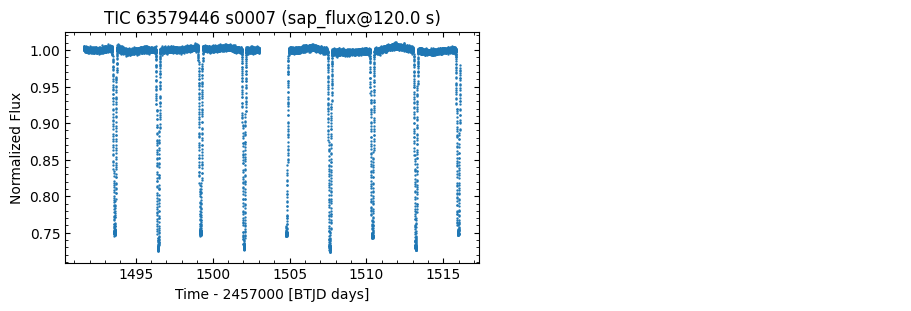

In [50]:
lcs_titles = [f"{target} s{l.sector:04d} ({l.meta['FLUX_ORIGIN']}@{l.meta['FRAMETIM']*l.meta['NUM_FRM']} s)" for l in lcs]
plt.show(_fig := plots.plot_lightcurves(lcs, "flux", lcs_titles, normalize_lcs=True))
plt.close(_fig)

### Process the light curves to create flattened copies with delta_mag columns

First we select regions to exclude from processing. These could be distorted regions of the
light curve, incomplete eclipses or isolated regions with no useful data. Currently there is
no tool for selecting ranges from the light curve plot directly, so instead we parse the text
of an exclude list of (from, to) time tuples taken from all sectors. For example;
```python
[(1420.0, 1424.0), (2158.0, 2160.0)]
```
where the time values are interpreted with the time format and scale of each light curve.

Once we have any time masks we can use these, along with a simple mask which excludes
invalid flux values, to create masked copies of the original light curves. The masked
light curves are then extended with `delta_mag` and `delta_mag_err` columns calculated
from the fluxes. The `delta_mag` values are detrended and rectified in contiguous segments,
which are selected by finding gaps in the timeseries > gap threshold. Each segment is
rectified and detrended by subtracting a fitted polynomial of the selected degree. 

In [51]:
display(VBox(children=[
    (combine_sectors := Checkbox(description=f"Combine {num_sectors} sector(s)", value=target_config.get("combine_sectors", False),
                                 indent=False, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    (time_masks_text := Text(description="Time ranges to exclude:", value=f"{target_config.get('quality_masks', '')}",
                             layout={'width': "50%"}, style={'description_width': 'max-content'})),

    (seg_gap_th := FloatLogSlider(description="segment gap threshold (d):", value=target_config.get("detrend_gap_th", 2.0),
                                  base=10, min=-1, max=3, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    HBox(children=[
        (poly_degr := IntSlider(description="detrend poly degree:", value=target_config.get("detrend_poly_degree", 1),
                                min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (dtrd_iters := IntSlider(description="detrend iterations:", value=target_config.get("detrend_iterations", 2),
                                 min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
])]))

In [52]:
time_mask_list = []
if len(time_masks_text.value.strip()): # Interpret the list of (from, to) tuples entered above
    time_mask_list = literal_eval(time_masks_text.value)
    if isinstance(time_mask_list, (tuple, int, float)):
        time_mask_list = [time_mask_list]

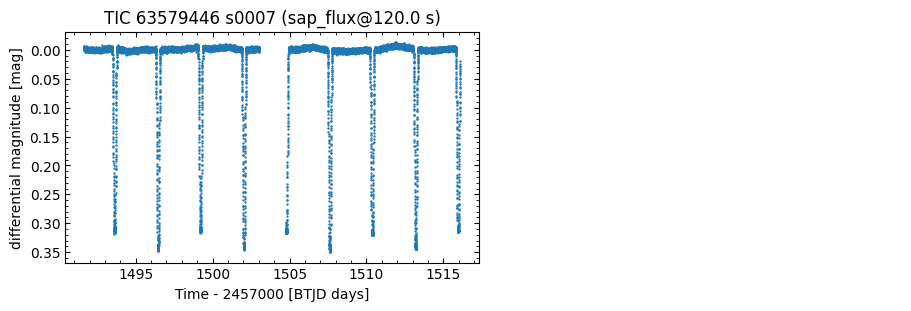

In [53]:
mag_lcs = lk.LightCurveCollection([])
if combine_sectors.value and len(lcs):
    _norm_lcs = [lcs.stitch(lambda lc: lc.normalize())]
    lcs_titles = [f"{target} over {num_sectors} sector(s)"]
else:
    _norm_lcs = (lc.normalize() for lc in lcs)
    
for norm_lc in _norm_lcs:
    # Mask out any invalid fluxes and requested time ranges
    _qual_mask = lightcurves.create_invalid_flux_mask(norm_lc)
    for time_mask_range in (lightcurves.to_lc_time(t, norm_lc) for t in time_mask_list):
        _qual_mask &= (norm_lc.time < np.min(time_mask_range)) | (norm_lc.time > np.max(time_mask_range))
    norm_lc = norm_lc[_qual_mask]

    # Create detrended & rectified delta_mag and delta_mag err columns
    lightcurves.append_magnitude_columns(norm_lc, "delta_mag", "delta_mag_err")
    for s in lightcurves.find_lightcurve_segments(norm_lc, threshold=seg_gap_th.value * u.d):
        norm_lc[s]["delta_mag"] -= lightcurves.fit_polynomial(norm_lc.time[s], norm_lc[s]["delta_mag"],
                                                              poly_degr.value, dtrd_iters.value, 1.0)
    mag_lcs.append(norm_lc)
del _norm_lcs

plt.show(_fig := plots.plot_lightcurves(mag_lcs, "delta_mag", lcs_titles))
plt.close(_fig)

### Review phase folded light curves
First we lookup for the system's ephemeris in the TESS-ebs catalogue based on its TIC. If nothing found then the primary epoch and orbital period must be set manually by inspecting the light curves above.

By default the T0 time is expected to be the time of a primary eclipse. The phase folded light curves will be phase normalized when folded about this point (which becomes phase 0).

In [54]:
_default_t0, _default_period = None, None
if (result := tess_ebs_catalog.query_object(mag_lcs[0].meta["OBJECT"])):
    _default_t0, _default_period = result[0]["BJD0"][0], result[0]["Per"][0]
elif (result := gaia_tbosb_catalog.query_object(search_term)):
    _default_period = result[0]["Per"][0]

display(HBox(children=[
    (t0_text := FloatText(description="Primary epoch (btjd):",  value=target_config.get("t0",  _default_t0),
                          style={'description_width': 'max-content'})),
    (period_text := FloatText(description="Orbital period (d):", value=target_config.get("period", _default_period),
                              style={'description_width': 'max-content'})),
    (double_check := Checkbox(description="Use orbital period x2", value=target_config.get("double_period", False),
                              style={"description_width": "max-content"})),
]))

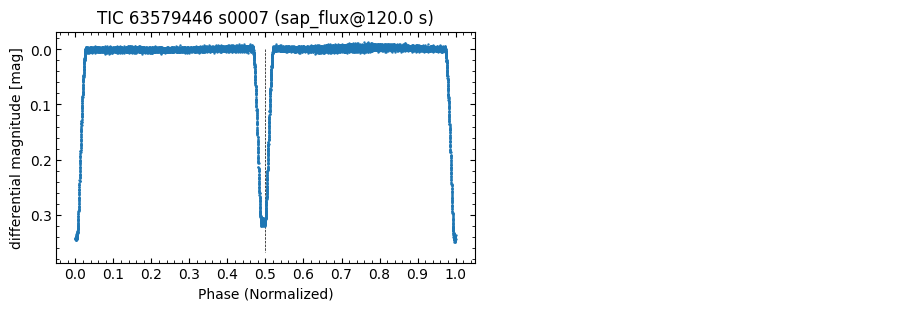

In [55]:
t0 = lightcurves.to_lc_time(t0_text.value, mag_lcs[0])
period = (2 if double_check.value else 1) * (period_text.value * u.d)

def _format_phases(_, ax):
    ax.vlines([0.5], 0, max(ax.get_ylim()), "k", "--", lw=0.5, zorder=-10)
    ax.set_xticks(np.arange(0.0, 1.1, 0.1))

_fig = plots.plot_lightcurves([*(lc.fold(period, t0, wrap_phase=u.Quantity(1), normalize_phase=True) for lc in mag_lcs)],
                             "delta_mag", lcs_titles, ax_func=_format_phases)
plt.show(_fig)
plt.close(_fig)

### Create sampled, phase folded mags data for use with EBOP MAVEN
We now need to make sampled copies of phase folded & phase normalized light curves for
each sector. The EBOP MAVEN model will tell us what wrap it expects for the folded light curves
for estimations through its `mags_feature_wrap_phase` attribute. This will have a value between
0 and 1, or `None`;
- a numeric value indicates the fixed phase above which phased data is expected to be wrapped
to a negative phase
    - a value of 0.75 indicates a phase range of -0.24999 to 0.75, centred on phase 0.25
- a value of `None` indicates the wrap is to ensure the resulting data is centred on the
mid-point between the primary and secondary eclipse
    - in this case the value is calculated from the phase of the secondary eclipse
    which can be set below

In [56]:
if estimator.mags_feature_wrap_phase is None:
    display(HBox(children=[
        (phiS_slider := FloatSlider(description="Phase of secondary eclipse:", value=target_config.get("phiS", 0.5),
                                    min=.01, max=.99, step=.01, layout={"width": "33%"}, style={'description_width': 'max-content'})),
    ]))

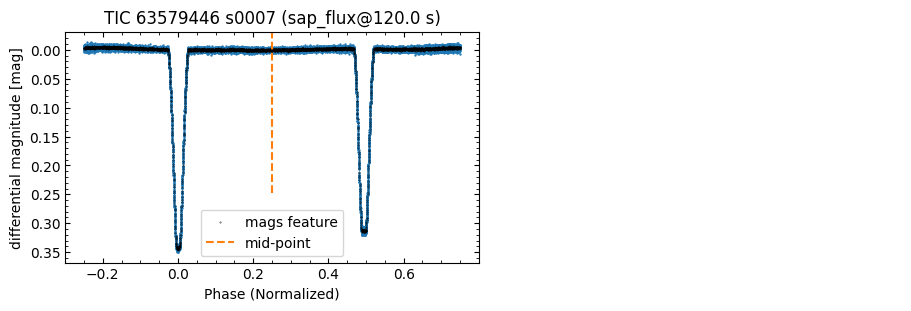

In [57]:
mags_bins = estimator.mags_feature_bins
wrap_phase = u.Quantity(estimator.mags_feature_wrap_phase or (0.5 + phiS_slider.value / 2))
binned_fold = np.zeros(shape=(len(mag_lcs), 2, mags_bins), dtype=np.float32)

_flcs = []
for ix, lc in enumerate(mag_lcs):
    _flcs.append(flc := lc.fold(period, t0, wrap_phase=wrap_phase, normalize_phase=True))
    binned_fold[ix] = lightcurves.get_binned_phase_mags_data(flc, mags_bins, wrap_phase)

def _plot_feature_and_mid(ix, ax):
    ax.scatter(binned_fold[ix, 0], binned_fold[ix, 1], s=0.33, c="k", marker=".", label="mags feature")
    ax.vlines(0.5, 0.3, 1, "tab:orange", "--", lw=1.5, transform=ax.transAxes, label="mid-point")

_fig = plots.plot_lightcurves(_flcs, "delta_mag", lcs_titles, ax_func=_plot_feature_and_mid, legend_loc="best")
plt.show(_fig)
plt.close(_fig)

### Estimate fitting input parameters with EBOP MAVEN
The EBOP MAVEN model will predict values for $r_{\rm A}+r_{\rm B}$, $k$, $J$, $e\cos{\omega}$,
$e\sin{\omega}$ and $b_{\rm P}$ for use as `JKTEBOP` fitting input parameters. To these we will
need to add values for $i$, which can be calculated from the 6 predicted values.

In [58]:
predictions = estimator.predict(binned_fold[:, 1], iterations=1000)
predictions = pipeline.append_calculated_inc_predictions(predictions, "inc")

for lc, preds in zip(mag_lcs, predictions):
    print(f"\nJKTEBOP input parameters for {target} sector {lc.meta['SECTOR']}")
    print(*(f"{p:>12s}: {preds[p] or 0:11.6f}" for p in predictions.dtype.names), sep="\n")


JKTEBOP input parameters for TIC 63579446 sector 7
  rA_plus_rB:    0.173676+/-   0.009729
           k:    0.559327+/-   0.016197
           J:    0.996952+/-   0.035277
       ecosw:   -0.013086+/-   0.005188
       esinw:   -0.024788+/-   0.012074
          bP:    0.297209+/-   0.017042
         inc:   88.148586+/-   0.151293


### Estimate limb darkening parameters
We have starting effective temperature and surface gravity values in the
TESS metadata stored with the light curves, however this refers to system
as a whole. We use J as a simple proxy for the ratio of effective temperatures.

In [59]:
teff_sys = ufloat(mag_lcs[0].meta.get("TEFF", None) or 5650, 300)
logg_sys = ufloat(mag_lcs[0].meta.get("LOGG", None) or 4.0, 0.1)

_J = np.mean(predictions["J"])
_teff = (teff_sys, teff_sys * _J) if _J.n < 1 else (teff_sys / _J, teff_sys)
display(VBox(children=[
    HBox(children=[
        (teffA_text := FloatSlider(description="Effective temp star A (K):", value=_teff[0].n, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggA_text := FloatSlider(description="log(g) star A (dex):", value=logg_sys.n, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),    
    ]),
    HBox(children=[
        (teffB_text := FloatSlider(description="Effective temp star B (K):", value=_teff[1].n, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggB_text := FloatSlider(description="log(g) star A (dex):", value=logg_sys.n, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),
    ]),
]))

In [60]:
_ldA_coeffs = limb_darkening.lookup_pow2_coefficients(loggA_text.value, teffA_text.value)
_ldB_coeffs = limb_darkening.lookup_pow2_coefficients(loggB_text.value, teffB_text.value)
ld_params = {
    "LDA": "pow2", "LDA1": _ldA_coeffs[0], "LDA2": _ldA_coeffs[1],
    "LDB": "pow2", "LDB1": _ldB_coeffs[0], "LDB2": _ldB_coeffs[1],
}

### Perform JKTEBOP Task 3 analysis
First we set up the in and dat files for each analysis to be run.

In [61]:
# Superset of all of the potentially fitted parameters
fitted_param_names = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "pe", "period", "rA", "rB", "LA", "LB", "light_ratio"]
fitted_params = np.empty(shape=(len(mag_lcs), ), dtype=[(k, np.dtype(UFloat.dtype)) for k in fitted_param_names])

In [62]:
task = 3
fit_dir = jktebop.get_jktebop_dir()
file_fmt = f"quick-fit-{target_file_stem}-{{sector:04d}}.{{ext:s}}"
for ix, (lc, preds) in enumerate(zip(mag_lcs, predictions)):
    _in_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="in")
    _dat_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="dat")
    _par_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="par")

    _in_params = {
        "task": task,
        "qphot": preds["k"]**1.4,
        "gravA": 0.,                "gravB": 0.,
        "L3": 0.,

        "reflA": 0.,                "reflB": 0.,
        "period": period.value,
        "primary_epoch": t0.value,
        
        "simulations": 100 if task == 8 else "",

        "qphot_fit": 0,
        "ecosw_fit": 1,             "esinw_fit": 1,
        "gravA_fit": 0,             "gravB_fit": 0,
        "L3_fit": 1,
        "LDA1_fit": 1,              "LDB1_fit": 1,
        "LDA2_fit": 0,              "LDB2_fit": 0,
        "reflA_fit": 1,             "reflB_fit": 1,
        "sf_fit": 1,
        "period_fit": 1,            "primary_epoch_fit": 1,

        "data_file_name": _dat_fname.name,
        "file_name_stem": _dat_fname.stem,

        **{ n: preds[n] for n in preds.dtype.names },
        **ld_params,
    }

    # JKTEBOP will fail if it finds files from a previous fitting
    for file in fit_dir.glob(file_fmt.format(sector=lc.meta["SECTOR"], ext="*")):
        file.unlink()
    _segments = lightcurves.find_lightcurve_segments(lc, 0.5, yield_times=True)
    _append_lines = jktebop.build_poly_instructions(_segments, "sf", 1) + ["", "chif", ""]
    jktebop.write_in_file(_in_fname, append_lines=_append_lines, **_in_params)
    jktebop.write_light_curve_to_dat_file(lc, _dat_fname)

    # Blocks on the JKTEBOP task until we can parse the newly written par file contents
    # to read out the revised values for the superset of potentially fitted parameters.
    _pgen = jktebop.run_jktebop_task(_in_fname, _par_fname, stdout_to=sys.stdout)
    for k, v in jktebop.read_fitted_params_from_par_lines(_pgen, fitted_param_names, True).items():
        fitted_params[ix][k] = v

  
JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  quick-fit-tic-63579446-0007.par                   
>> Opened new LC output  file:  quick-fit-tic-63579446-0007.out                   
>> Opened new model fit  file:  quick-fit-tic-63579446-0007.fit                   
>> Read  16310 datapoints (with errors) from file quick-fit-tic-63579446-0007.dat                   
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 26 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:   1.945 
>> Done iteration 2 to adjust errorbars. Chisqred values:   1.000 
>> Best fit has been found after 12 iterations.
  


#### Report of JKTEBOP fitting results

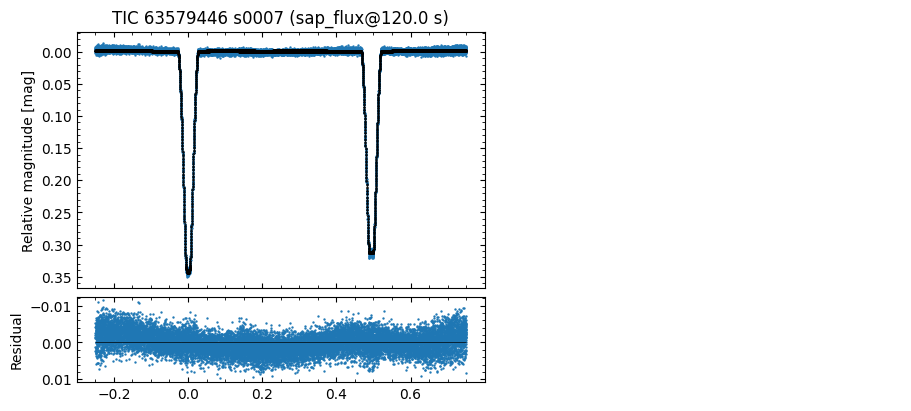

In [63]:
if task == 3:
    rows, cols = int(np.ceil(len(mag_lcs) / 2)), 2
    fig, axes = plt.subplots(rows*2, cols, figsize=(4.5*cols, 4*rows), height_ratios=(3, 1)*rows, constrained_layout=True)

    for ix in range(axes.size//2):
        row, col = int(np.floor(ix / cols) * 2), ix % cols
        ax_lc, ax_res = axes[row, col], axes[row+1, col]
        if ix < len(mag_lcs):
            # Pick columns so they are ordered [phase, lc_mag, model_mag, residual]
            out_file = fit_dir / file_fmt.format(sector=mag_lcs[ix].meta['SECTOR'], ext="out")
            out_data = np.loadtxt(out_file, float, comments="#", usecols=[3, 1, 4, 5], unpack=True)
            out_data[0][out_data[0] > wrap_phase.value] -= 1. # matches wrap used previously
        
            if ix < len(mag_lcs):
                ax_lc.scatter(out_data[0], out_data[1], s=2.0, marker=".", label=None)
                ax_lc.scatter(out_data[0], out_data[2], s=0.5, c="k", marker=".", label=None)
                ax_res.scatter(out_data[0], out_data[3], s=2.0, marker=".", label=None)
                ax_res.hlines([0.0], min(out_data[0]), max(out_data[0]), ls="-", color="k", lw=.5)

                if ix == 0:
                    ax_lc.invert_yaxis()
                    ax_res.invert_yaxis()
                else:
                    ax_lc.sharey(axes[0, 0])
                    ax_res.sharey(axes[1, 0])
        
                # Hides tick labels on inner facing shared axes
                plt.setp(ax_lc.get_xticklabels(), visible=False) 
                if col > 0:
                    plt.setp(ax_lc.get_yticklabels(), visible=False)
                    plt.setp(ax_res.get_yticklabels(), visible=False)
                plots.format_axes(ax_lc, title=lcs_titles[ix], ylabel="" if ix % cols else "Relative magnitude [mag]")
                plots.format_axes(ax_res, ylabel="" if ix % cols else "Residual")
        else:
            ax_lc.axis("off")
            ax_res.axis("off")
    plt.show(fig)
    plt.close(fig)

In [64]:
print(("Mean f" if len(fitted_params) > 1 else "F") + f"itted parameter values for {target} over {num_sectors} sector(s)")
print("\n".join(f"{p:>14s}: {fitted_params[p].mean():12.6f}" for p in fitted_params.dtype.names))

Fitted parameter values for TIC 63579446 over 1 sector(s)
    rA_plus_rB:     0.170016+/-    0.000124
             k:     0.603753+/-    0.004309
             J:     1.029806+/-    0.017200
         ecosw:    -0.009859+/-    0.000016
         esinw:    -0.007083+/-    0.001447
           inc:    88.599309+/-    0.058624
            L3:     0.052653+/-    0.008120
            pe:  1496.454490+/-    0.000050
        period:     5.582885+/-    0.000021
            rA:     0.106011+/-           0
            rB:     0.064004+/-           0
            LA:     0.696436+/-           0
            LB:     0.250911+/-           0
   light_ratio:     0.360279+/-           0


### Load our support data for MCMC fitting the target's SED

Load the PySSED bt-settle model and set up the related model functions.

__Note:__ The data file is currently a copy of that kindly published on [GitHub](https://github.com/iain-mcdonald/PySSED)
by [McDonald at al., (2024)](https://ui.adsabs.harvard.edu/abs/2024RASTI...3...89M/abstract)

In [65]:
# Read the pre-built bt-settl model file
model_sed = ModelSed("libs/data/pyssed/model-bt-settl-recast.dat")

print(f"Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:")
print(f"wavelength {model_sed.wavelength_range:unicode}, Teff {model_sed.teff_range:unicode}",
      f"and logg {model_sed.logg_range:unicode}")

Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:
wavelength [ 0.3 22. ] µm, Teff [ 1900. 70000.] K and logg [-0.5  6. ] dex


In [66]:
# Extinction model: G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model which covers the range from",
      f"{min(ext_wl_range)} to {max(ext_wl_range)}.")

Using the G23 extinction model which covers the range from 0.0912 um to 32.0 um.


### Locate and prepare the target's spectral energy distribution (SED) data
We can query the target's SED with the Vizier SED service which aggregates
flux measurements from various systematic sky surveys. Once we have this
we need to deredden the SED prior to fitting for stellar masses

In [67]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
# Work in Jy rather than W/m^2/Hz as they are a more natural unit, giving values that minimize 
# potential FP rounding. Plots are agnostic and plot wl [um] and vF(v) [W/m^2] on x and y.
sed = get_sed_for_target(target, search_term, radius=0.1, remove_duplicates=True, verbose=True,
                         freq_unit=u.GHz, flux_unit=u.Jy, wl_unit=u.um)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.ones((len(sed)), dtype=bool)
model_mask &= np.array([model_sed.has_filter(f) for f in sed["sed_filter"]])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) \
            & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_sed.wavelength_range)) \
            & (sed["sed_wl"] <= max(model_sed.wavelength_range))
sed = sed[model_mask]

sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering",
      "\nwith the units for flux, frequency and wavelength being",
      ", ".join(f"{sed[f].unit:unicode}" for f in ["sed_flux", "sed_freq", "sed_wl"]))

Opened SED table tic-63579446-0.1.vot containing 74 row(s).
Dropped 37 duplicate(s) leaving 37 unique row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 14 group(s) from 37 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
12 unique SED observation(s) retained after range and outlier filtering 
with the units for flux, frequency and wavelength being Jy, GHz, µm


In [68]:
for val, flags in extinction.get_ebv(target_coords, rv=ext_model.Rv):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: E(B-V) = {val:.6f}")
        sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.156 s
  pix_info:   0.336 s
   samples:  14.117 s
      best:   3.032 s
       nan:   0.019 s
      sort:   7.578 s
       idx:   0.074 s
Found extinction with get_bayestar_ebv: E(B-V) = 0.029880


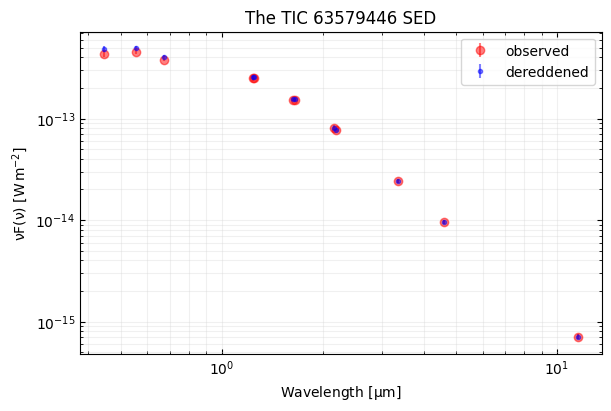

In [69]:
plt.show(plots.plot_sed(sed["sed_wl"].quantity,
                        fluxes=[sed["sed_flux"].quantity, sed["sed_der_flux"].quantity],
                        flux_errs=[sed["sed_eflux"].quantity]*2,
                        fmts=["or", ".b"],
                        labels=["observed", der_lab],
                        title=f"The {target} SED"))
plt.close()

### Set up the functions which will support SED fitting
The `num_stars` and `fit_mask` are fixed values indicating the number of stars
to fit for and which `theta` parameters are fitted (True) or fixed (False).

In [70]:
num_stars = 2

fit_mask = np.array(
    [True] * num_stars +    # teff
    [True] * num_stars +    # radius
    [False] * num_stars +   # logg
    [False]                 # distance
)

First we set up the prior criteria against which candidate model parameters
will be evaluated.

In [71]:
teff_ratio = (fitted_params["light_ratio"].mean() / fitted_params["k"].mean()**2)**0.25
teff_ratio_sigma = max(teff_ratio.n * 0.05, teff_ratio.s)
radius_ratio = fitted_params["k"].mean().n
radius_ratio_sigma = max(radius_ratio * 0.05, fitted_params["k"].mean().s)

prior_criteria = create_prior_criteria(
    teff_limits=tuple(model_sed.teff_range.to(u.K).value),
    radius_limits=(0.1, 1000),
    logg_limits=tuple(model_sed.logg_range.value),
    dist_limits=(0, np.inf),
    teff_ratios=teff_ratio,
    teff_ratio_sigmas=teff_ratio_sigma,
    radius_ratios=radius_ratio,
    radius_ratio_sigmas=radius_ratio_sigma,
    logg_ratios=1,
    nstars=2,
    verbose=True
)

prior_criteria[0]:  (1900.0, 70000.0), (1900.0, 70000.0), (0.1, 1000), (0.1, 1000), (-0.5, 6.0), (-0.5, 6.0), (0, inf)
prior_criteria[1]:  1.000e+00, 9.971e-01, 1.000e+00, 6.038e-01, 1.000e+00, 1.000e+00, 1.000e+00
prior_criteria[2]:  0.000e+00, 4.985e-02, 0.000e+00, 3.019e-02, 0.000e+00, 0.000e+00, 0.000e+00


Next we set up `theta0` which is the starting position for fitting based on published values
for $T_{\rm eff}$ and $T_{\rm eff}$ ratio calculated from the fitted parameters,
the fitted value for the ratio of the radii ($k$), the distance published by _Gaia_
and a default value for the $\log{g}$.

In [72]:
theta_plot_labels = np.array([r"$T_{\rm eff,A}/{\rm K}$", r"$T_{\rm eff,B}/{\rm K}$",
                     r"$R_{\rm A}/{\rm R_{\odot}}$", r"$R_{\rm B}/{\rm R_{\odot}}$",
                     r"$\log{g}_{\rm A}$", r"$\log{g}_{\rm B}$", r"$D/{\rm pc}$"])
theta_labels = np.array([("TeffA", model_sed.teff_range.unit), ("TeffB", model_sed.teff_range.unit),
                ("RA", u.Rsun), ("RB", u.Rsun), ("loggA", u.dex), ("loggB", u.dex), ("dist", u.pc)])

theta0 = create_theta(
    teffs=[teff_sys.n, teff_sys.n * teff_ratio.n] if teff_ratio.n <= 1 else [teff_sys.n / teff_ratio.n, teff_sys.n],
    radii=[1.0, fitted_params["k"].mean().n],
    loggs=[logg_sys.n] * num_stars,
    dist=target_coords.distance.to(u.pc).value,
    nstars=num_stars,
    verbose=True
)

theta:	 6.213e+03, 6.195e+03, 1.000e+00, 6.038e-01, 3.900e+00, 3.900e+00, 4.982e+02


This is a function which plots the fitted vs observed SED data.

In [73]:
def plot_fitted_model(sed, theta, title):
    # Generate model SED fluxes at points x for each set of component star params in theta
    x = model_sed.get_filter_indices(sed["sed_filter"])
    comp_flux = model_func(theta, x, model_sed.get_fluxes, combine=False) * model_sed.flux_unit
    sys_flux = np.sum(comp_flux, axis=0)

    # Plot the fitted model against the derredened SED + show each star's contribution
    fig = plots.plot_sed(x=sed["sed_wl"].to(u.um),
                         fluxes=[sed["sed_der_flux"].quantity, sys_flux, comp_flux[0], comp_flux[1]],
                         flux_errs=[sed["sed_eflux"].quantity, None, None, None],
                         fmts=["ob", ".k", "*g", "xr"],
                         labels=["dereddened SED", "fitted pair", "fitted star A", "fitted star B"],
                         title=title)
    plt.show(fig)
    plt.close(fig)

#### Run a "quick" minimize fit

In [74]:
theta_min_fit, _ = minimize_fit(x=model_sed.get_filter_indices(sed["sed_filter"]),
                                y=sed["sed_der_flux"].quantity.to(model_sed.flux_unit).value,
                                y_err=sed["sed_eflux"].quantity.to(model_sed.flux_unit).value,
                                prior_criteria=prior_criteria,
                                theta0=theta0,
                                fit_mask=fit_mask,
                                flux_func=model_sed.get_fluxes,
                                verbose=True)

minimize_fit(theta0=[6.213e+03*, 6.195e+03*, 1.000e+00*, 6.038e-01*, 3.900e+00, 3.900e+00, 4.982e+02])
(Nelder-Mead) succeeded after 172 iterations & 300 function evaluation(s) [fun = 1.584616]
(SLSQP) succeeded after 32 iterations & 167 function evaluation(s) [fun = 1.584616]
(None) failed [Desired error not necessarily achieved due to precision loss.] after 50 iterations & 457 function evaluation(s) [fun = 1.584616]
The best fit with Nelder-Mead method yielded theta=[6.088e+03*, 6.071e+03*, 1.764e+00*, 1.065e+00*, 3.900e+00, 3.900e+00, 4.982e+02]


Best fit parameters for TIC 63579446 from minimization fit (* indicates fitted parameter): 
       TeffA* = 6088.469 K 
       TeffB* = 6070.692 K 
          RA* = 1.764 R☉ 
          RB* = 1.065 R☉ 
       loggA  = 3.900 dex 
       loggB  = 3.900 dex 
        dist  = 498.241 pc


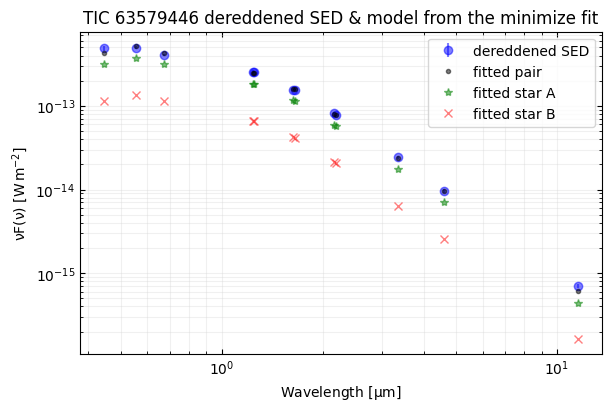

In [75]:
print(f"Best fit parameters for {target} from minimization fit (* indicates fitted parameter):",
      *(f"\n{l:>12s}{'*' if f else ' ':s} = {t:.3f} {u:unicode}" 
                        for t, f, (l, u) in zip(theta_min_fit, fit_mask, theta_labels)))
plot_fitted_model(sed, theta_min_fit, f"{target} dereddened SED & model from the minimize fit")

### Perform MCMC fitting for more reliable fit from a probability distribution

In [76]:
thin_by = 10
_, sampler = mcmc_fit(x=model_sed.get_filter_indices(sed["sed_filter"]),
                      y=sed["sed_der_flux"].quantity.to(model_sed.flux_unit).value,
                      y_err=sed["sed_eflux"].quantity.to(model_sed.flux_unit).value,
                      prior_criteria=prior_criteria,
                      theta0=theta_min_fit,
                      fit_mask=fit_mask,
                      flux_func=model_sed.get_fluxes,
                      thin_by=thin_by,
                      processes=8,
                      early_stopping=True,
                      progress=True,
                      verbose=True)

mcmc_fit(theta0=[6.088e+03*, 6.071e+03*, 1.764e+00*, 1.065e+00*, 3.900e+00, 3.900e+00, 4.982e+02])
Running MCMC fit with 100 walkers for 100000 steps, thinned by 10, on 8 process(es). Early stopping is enabled after 2500 steps.


  8%|▊         | 8000/100000 [07:02<1:21:04, 18.91it/s]

Halting MCMC after 8,000 steps as the walkers are past 100 times the autocorrelation time & the fit has converged.
Autocorrelation steps (tau): 46.611, 47.748, 48.272, 44.066
Estimated burn-in steps:     96
Mean Acceptance fraction:    0.595
Nominals of fitted theta:    [6.088e+03*, 6.058e+03*, 1.767e+00*, 1.065e+00*, 3.900e+00, 3.900e+00, 4.982e+02]


Mean Acceptance fraction:    0.594838
Autocorrelation steps (tau): 46.611, 47.748, 48.272, 44.066
Estimated burn-in steps:     96


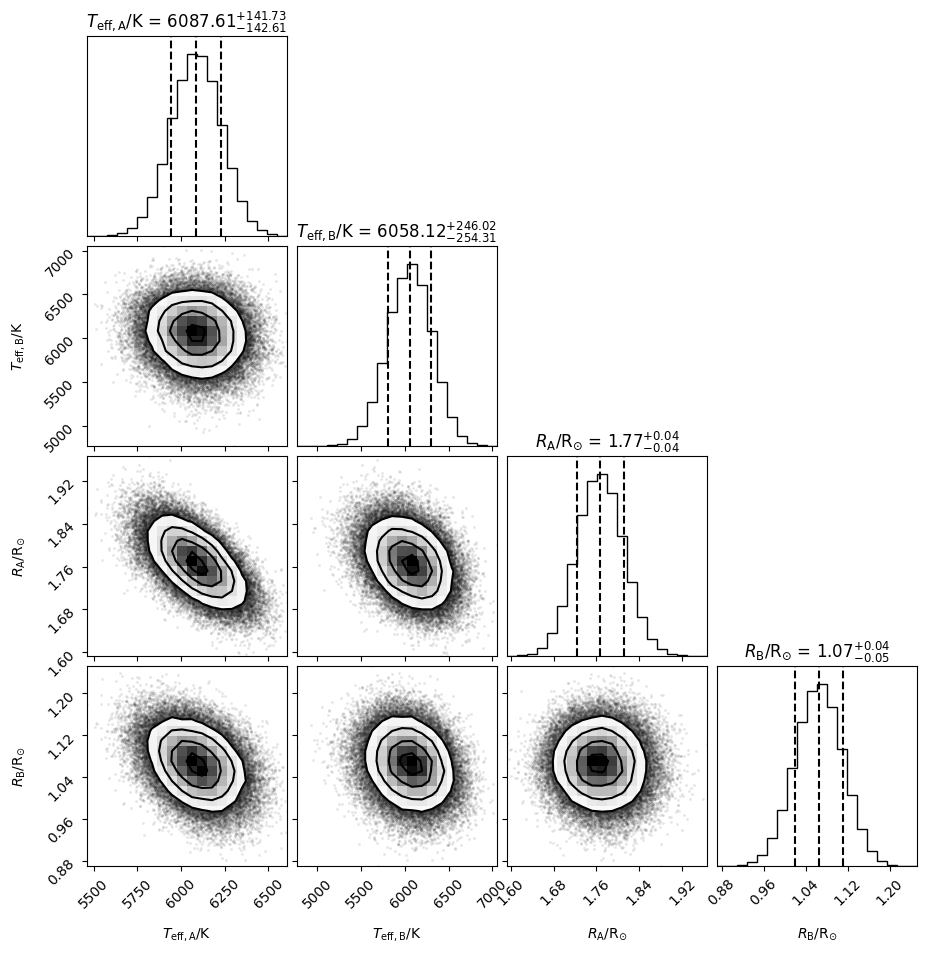

In [77]:
_accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction:    {_accept_frac:.6f}")
tau = sampler.get_autocorr_time(c=5, tol=50, quiet=True) * thin_by
print(f"Autocorrelation steps (tau):", ", ".join(f"{t:.3f}" for t in tau))
_burn_in_steps = int(max(np.nan_to_num(tau, copy=True, nan=1000)) * 2)
print(f"Estimated burn-in steps:     {_burn_in_steps:,}")

# Only the fitted params are in samples
samples = sampler.get_chain(discard=_burn_in_steps, flat=True)
plt.show(corner.corner(samples, show_titles=True, plot_datapoints=True,
                       quantiles=[0.16, 0.5, 0.84], labels=theta_plot_labels[fit_mask]))
plt.close()

Final fitted parameters for TIC 63579446 from MCMC fit 
       TeffA =  6087.595 +/- 141.777/142.586 K 
       TeffB =  6058.161 +/- 246.065/254.353 K 
          RA =  1.767 +/- 0.044/0.043 R☉ 
          RB =  1.065 +/- 0.045/0.045 R☉


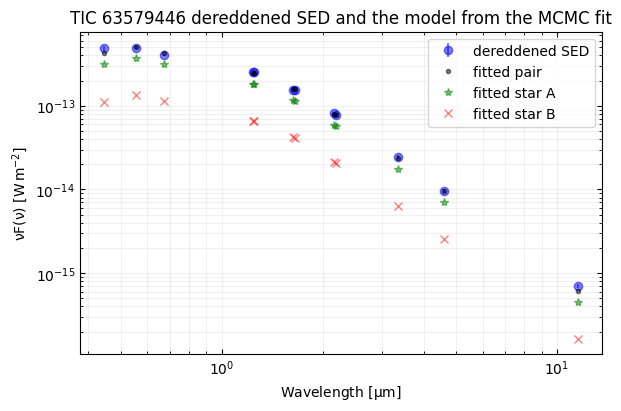

In [78]:
theta_mcmc_fit = np.median(samples[_burn_in_steps:], axis=0)
theta_err_high = np.quantile(samples[_burn_in_steps:], 0.84, axis=0) - theta_mcmc_fit
theta_err_low = theta_mcmc_fit - np.quantile(samples[_burn_in_steps:], 0.16, axis=0)

print(f"Final fitted parameters for {target} from MCMC fit",
      *(f"\n{l:>12s} = {t: .3f} +/- {th:.3f}/{tl:.3f} {u:unicode}" for t, th, tl, (l, u)
                        in zip(theta_mcmc_fit, theta_err_high, theta_err_low, theta_labels[fit_mask])))

# Having gone directly to the samples for its values, theta_mcmc_fit only contains the fitted params
theta_plot_fit = theta0.copy()
theta_plot_fit[fit_mask] = theta_mcmc_fit
plot_fitted_model(sed, theta_plot_fit, f"{target} dereddened SED and the model from the MCMC fit")